In [9]:
library(stringr)
library(scales)
library(Seurat)

1.The manuscript does not show that the cell-type quantity prediction was accurate. I could not conclude that the cell quantities were similar between human and mouse based on the results shown (see below). If data is simulated based on the human single cell RNA-seq, it can be shown that it can be predicted using the mouse data. For example, setting the level of each cell type, adding noise to test the quality of the pipeline, and then running and comparing the deconvolution with either the mouse single cell, the human single cell, and a random single cell data (by shuffling the labels of the cell types). Such analysis may enable to test the actual effect of deconvolving with mouse data.


Test another tissue type. 
https://www.sciencedirect.com/science/article/pii/S0022202X17330695?via%3Dihub#appsec1

In [129]:
# See notebook: human_skin_deconvolution.ipynb

2.In figure 2D, it seems like there are high positive and negative correlations between the quantities of many cell types, not necessarily the obvious ones. For example, there is a positive correlation of mouse endothelial cells with human hepatocytes type 4 and all the mouse cell types are positively correlated with most human cells. Why is that? It seems like all the other cell types, except for the hepatocytes, are very similar in their quantities. It might be an artifact due to the large effect of the hepatocytes. A comparison between the cell type quantities patterns within each organism may explain the observed values. Another option is to use human published datasets, containing both the bulk RNA-seq and cell type compositions; these datasets can be used to test the deconvolution accuracies using single cell data from mice compared to the appropriate human data (if available).

In [1]:
liver_celltypes_human <- data.frame(celltypes = c("abT_cell", "central_venous_sinusoidal_endothelial_cells", "Cholangiocytes", "gdT_cell", "Hepatic_Stellate_Cells",
                                                  "Hepatocytes0", "Hepatocytes1", "Hepatocytes3", "Hepatocytes4", "inflammatory_macrophages", "Kupffer_cell", "Mature_B_cells",
                                                  "NK.NKT_cell", "Periportal_sinusoidal_endothelial_cells", "Plasma_cell"),
                                   colors     = c("#db4e00", "#00c2c0", "#0a9d06", "#fa9c00", "#9ed242", "#b53bc7", "#641f52", "#f1a8f2", "#ff4bcc", "#cdad02",
                                                 "#f0d710", "#f77841", "#ff8e77", "#0075da", "#a00621"))

liver_celltypes_mouse <- data.frame(celltypes = c("B_cell", "endothelial_cell_of_hepatic_sinusoid", "hepatocyte", "Kupffer_cell", "natural_killer_cell"),
                                   colors  = c("#f77841", "#00c2c0", "#b53bc7", "#f0d710", "#ff8e77"))

In [2]:
heart_celltypes_mouse <- data.frame(celltypes = c("cardiac_neuron", "cardiac_muscle_cell", "endocardial_cell", "endothelial_cell", "fibroblast", "leukocyte",
                                                  "myofibroblast_cell", "smooth_muscle_cell"), 
                                    colors    = c("#b163b2", "#dc5227", "#2d73bb", "#1ebdbb", "#9fcc45", "#cdae2d", "#1a9f4a", "#f579bf")) 
                                    
                                    
                                    
heart_celltypes_human <- data.frame(celltypes = c("cardiomyocyte", "endothelial", "fibroblast"), 
                                    colors    = c("#dc5227", "#1ebdbb", "#9fcc45"))                                     

In [3]:
gtex_samples   = read.table("/publicdata/gtex_v7/GTEx_v7_Annotations_SampleAttributesDS_V2.txt", header = TRUE, sep = "\t")

gtex_samples_atrium = gtex_samples[gtex_samples$SMTSD == "Heart - Atrial Appendage", "SAMPID"]


In [4]:
liver_mouse = read.csv("../tables/Cibersort_out/CIBERSORT.Output_Job78_liver_mouse.csv")
liver_human = read.csv("../tables/Cibersort_out/CIBERSORT.Output_Job79_liver_human.csv")

In [143]:
skin_mouse = read.csv("../tables/Cibersort_out/CIBERSORT_reannotated_skin_mouse.csv")
skin_human = read.csv("../tables/Cibersort_out/CIBERSORT_skin_epidermis_human.csv")


In [6]:
liver_order = liver_human[order(-liver_human$Hepatocytes0, -liver_human$Hepatocytes3, -liver_human$Hepatocytes4), "Input.Sample"]
heart_order = heart_mouse[order(-heart_mouse$cardiac_muscle_cell, -heart_mouse$fibroblast), "Input.Sample"]

In [7]:
liver_celltypes_collapsed <- data.frame(celltypes = c("merged_Hepatocyte",
                                                      "merged_Endothelial",
                                                      "merged_Macrophage",
                                                      "merged_B_cell",
                                                      "merged_NK.NKT_cell",
                                                      "merged_Cholangiocyte",
                                                      "merged_Heptatic_stellate_cell"),
                                   colors  = c("#b53bc7", "#00c2c0", "#f0d710", "#f77841", "#ff8e77", "#0a9d06", "#9ed242"))

In [8]:
collapse = read.table("../tables/merged_human_liver_cibersort.txt", header = T)

In [10]:
collapse$fakecol1 <- NA
collapse$fakecol2 <- NA
collapse$fakecol3 <- NA

In [11]:
liver_human$endothelial <- liver_mouse$endothelial_cell_of_hepatic_sinusoid + liver_human$Periportal_sinusoidal_endothelial_cells
# liver_human$endothelial <- liver_human$central_venous_sinusoidal_endothelial_cells + liver_human$Periportal_sinusoidal_endothelial_cells

In [137]:
CorrPlotFrazer <- function(x, y, xmax, main){
    
    max2use = NA
    if(max(x) > max(y)){
    max2use = max(x)
    }else {
    max2use = max(y)
    }

    plot(x, y,
         xlim = c(0, (max2use + (max2use * .1))),
         ylim = c(0, (max2use + (max2use * .1))),
         las = 1, pch = 20, cex = 1.5, cex.main = .8,
         main = main, xlab = "Estimate from human", ylab = "Estimate from mouse")
    
    text(0, max2use,   paste("r = ", round(cor(x, y), 2), sep = ""), pos = 4, cex = .75) 
    text(0, max2use - (max2use * .1), paste("P = ", scientific(cor.test(x, y)$p.value, digits = 3), sep = ""), pos = 4, cex = .75)  
    
    lines(c(-0.1, 1.1), c(-0.1, 1.1))
    
}

In [25]:
cCells = read.table("../tables/merging_scheme_human_liver.txt", sep = "\t", header = T)

In [26]:
liver_human.wCollapsed <- liver_human[, !colnames(liver_human) %in% c("P.value", "Pearson.Correlation", "RMSE")]

for(i in seq(1, length(cCells$new_celltype))){
    
    x = c(str_split_fixed(cCells$merged_celltypes[i], ", ", 10))
    x = x[x != ""]    
    
    if(length(x) > 1){
        
        if(length(x[x %in% "central_venous_sinusoidal_endothelial_cells"]) != 1){
            liver_human.wCollapsed[paste("collapsed_", cCells$new_celltype[i], sep = "")] <- rowSums(liver_human.wCollapsed[, x])            
        
        }   
    }
}

In [78]:
liver_human.wCollapsed_names = c('Input.Sample', 'ab T cell', 'Central venous SEC', 'Cholangiocytes',
                                 'dg T cell', 'Hepatic Stellate cells', 'Hepatocytes0', 'Hepatocytes1', 'Hepatocytes3',
                                 'Hepatocytes4', 'Inflammatory macrophage', 'Kupffer', 'Mature B cell', 'NK/NKT cell',
                                 'Periportal SEC', 'Plasma cell', 'Collapsed endothelial', 'Collapsed hepatocyte',
                                 'Collapsed macrophage', 'Collapsed B cell', 'Collapsed NK/NKT cell') 

In [79]:
liver_mouse_names = c('Input.Sample', 'B cell', 'Endothelial', 'Hepatocyte',
                                 'Kupffer', 'NK cell', 'A', 'B', 'C') 

In [142]:
pdf("./review_liver_cell.estimate.cor.pdf", height = 11, width = 8.5)
par(mfrow = c(5,5))
figure_width  =  8.5
figure_height = 11
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

for (h.cell in seq(2, ncol(liver_human.wCollapsed))){
    for (m.cell in seq(2, ncol(liver_mouse) - 3)){
        
        if(! liver_human.wCollapsed_names[h.cell] == "Hepatocytes1" ){
        
            CorrPlotFrazer(liver_human.wCollapsed[, h.cell], liver_mouse[, m.cell], 1,
                           paste("human: ", liver_human.wCollapsed_names[h.cell], "\n", 
                                 "mouse: ", liver_mouse_names[m.cell], sep = ""))
 
        }
    }
}

dev.off()

png 
  2

In [150]:
skin_human =  skin_human[, ! colnames(skin_human) %in% c("X", "P.value", "Pearson.Correlation", "RMSE")]
skin_mouse =  skin_mouse[, ! colnames(skin_mouse) %in% c("Input.Sample", "P.value", "Pearson.Correlation", "RMSE")]

[1] "Outer.Bulge"

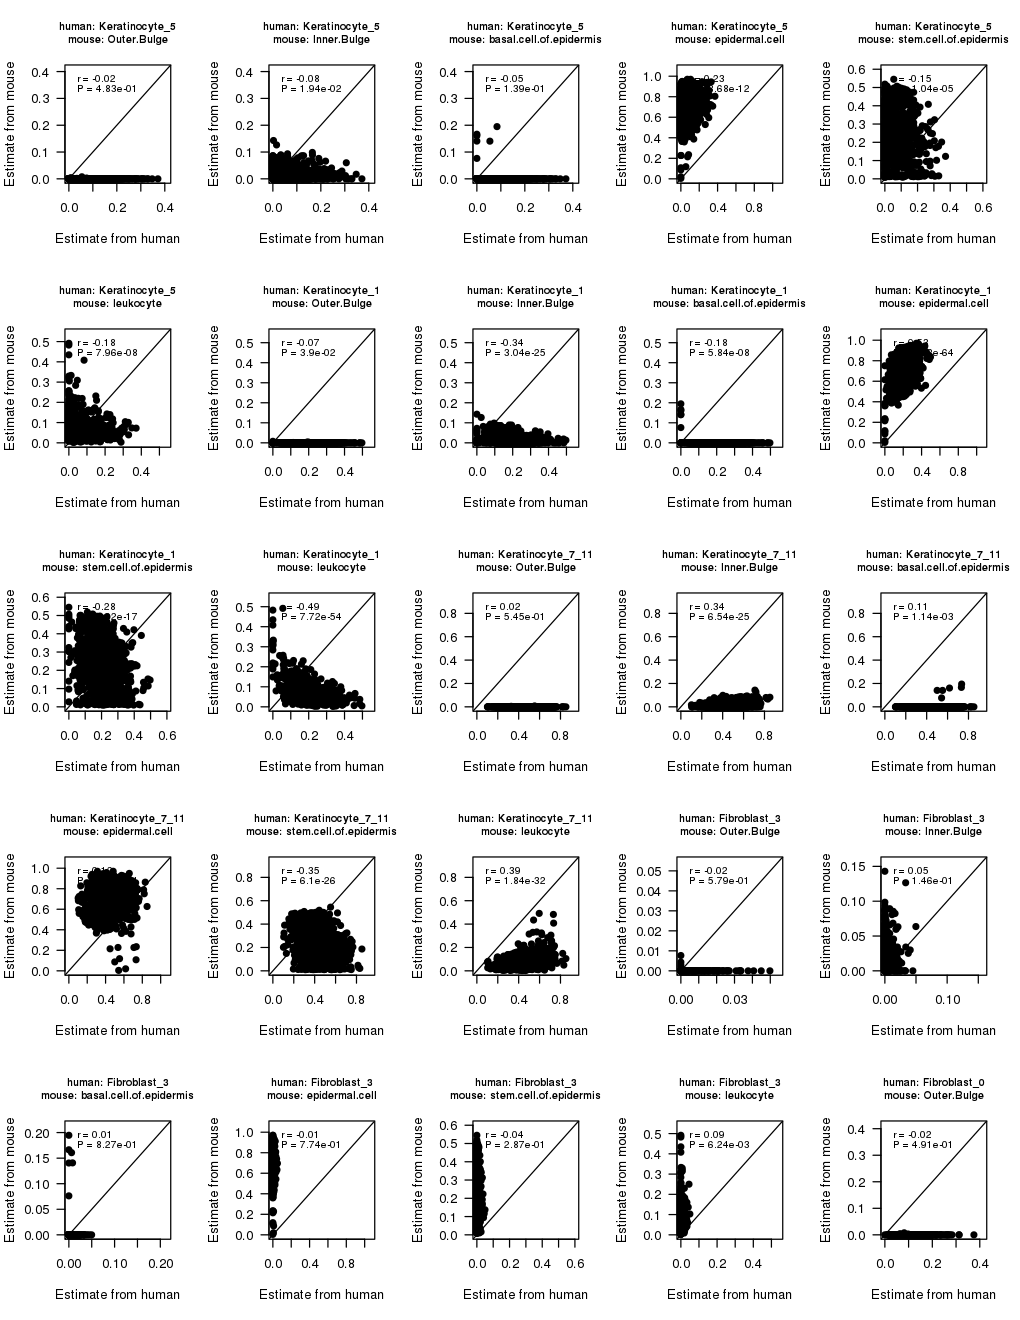

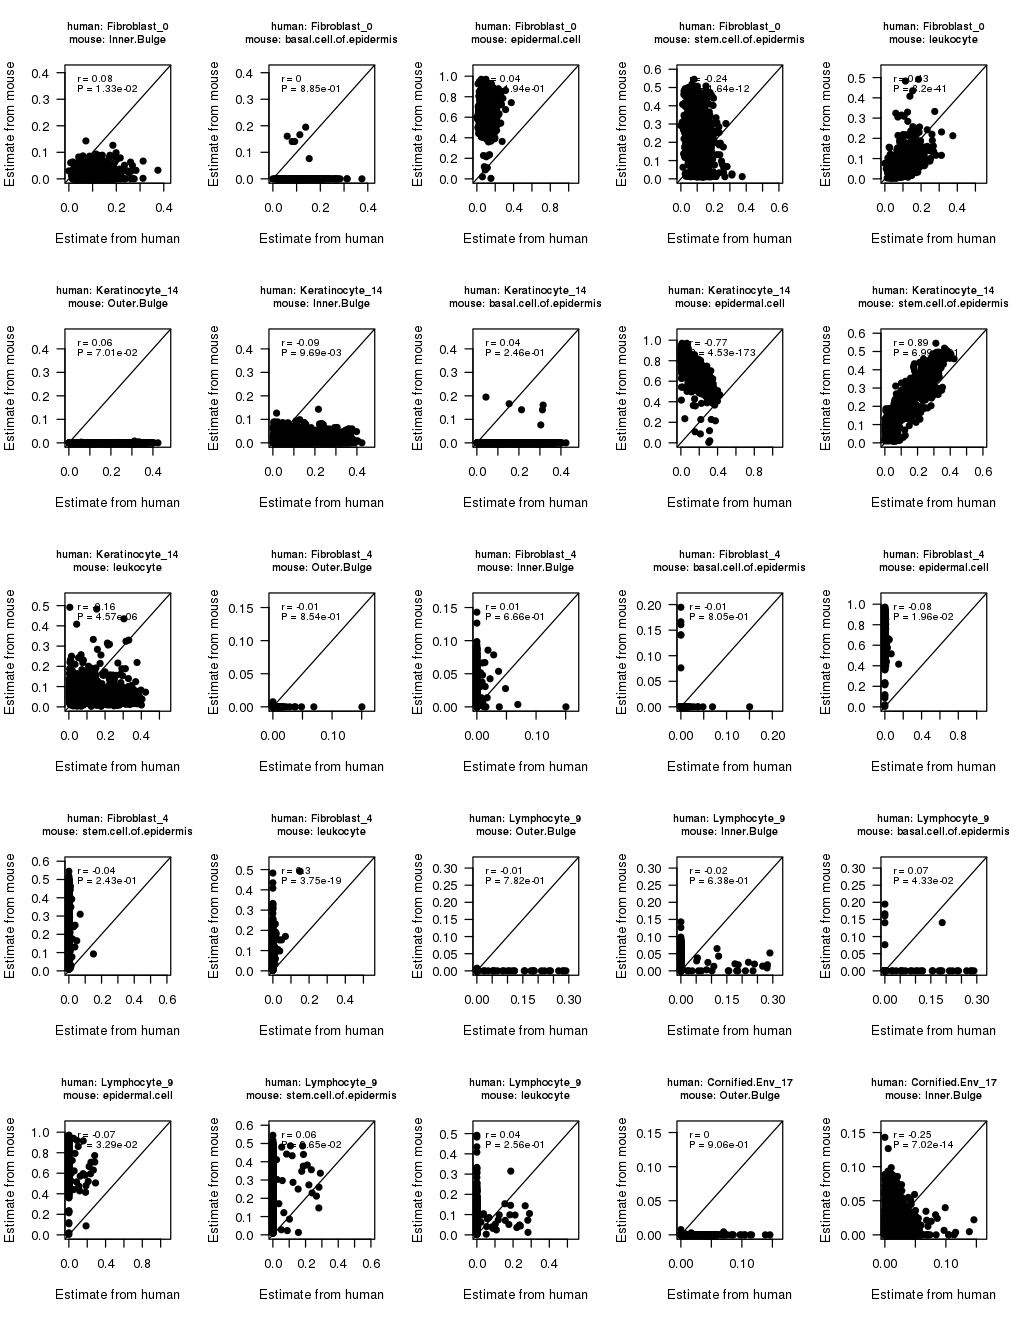

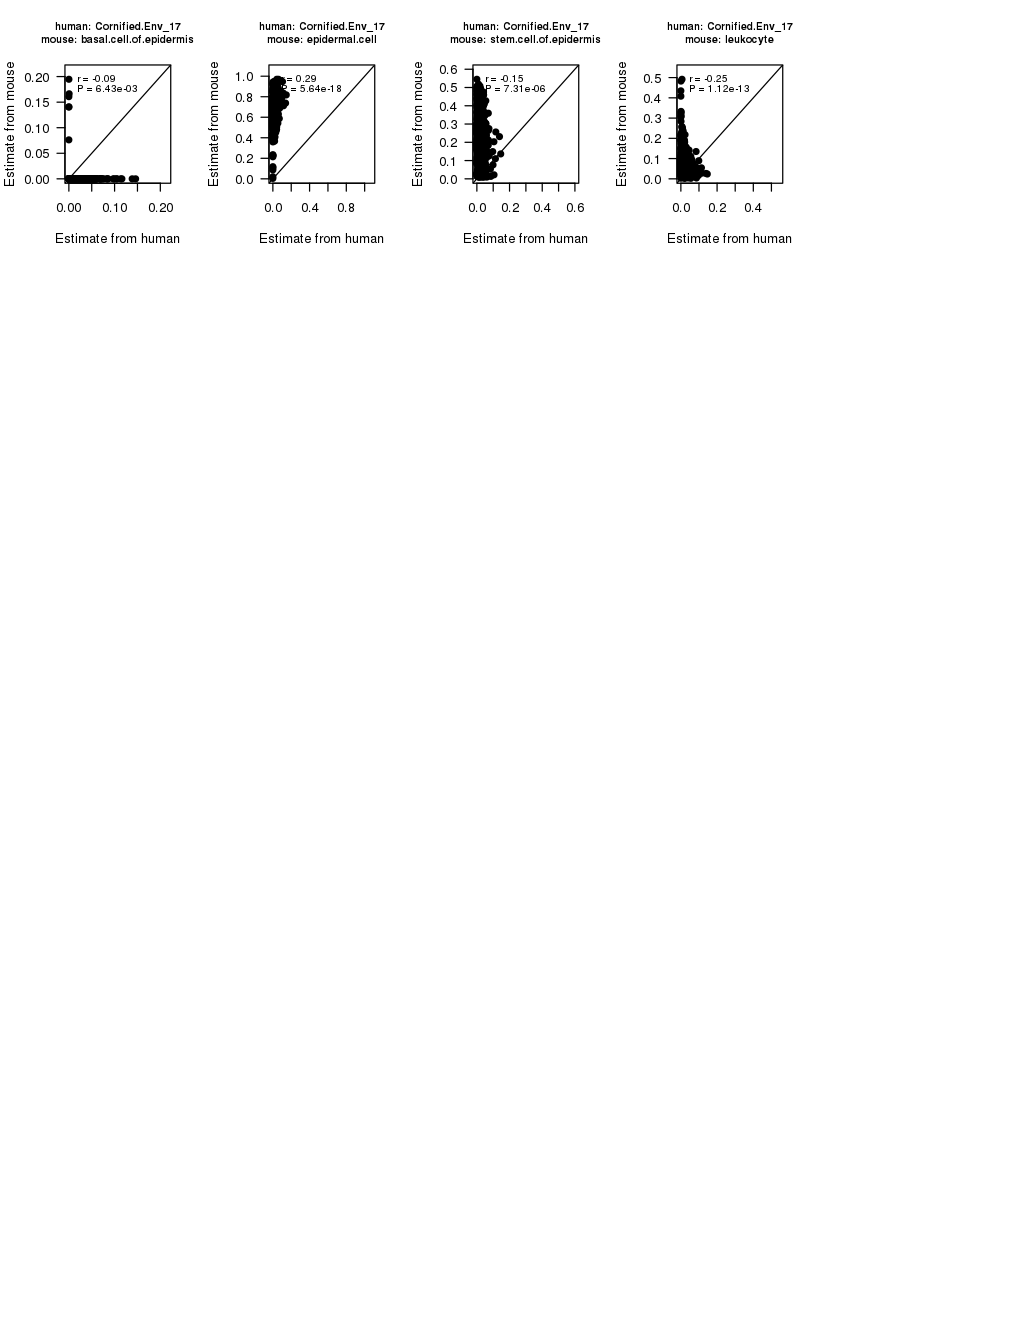

In [157]:
# pdf("./review_skin_cell.estimate.cor.pdf", height = 11, width = 8.5)
par(mfrow = c(5,5))
figure_width  =  8.5
figure_height = 11
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

for (h.cell in seq(1, ncol(skin_human))){
    for (m.cell in seq(1, ncol(skin_mouse))){
        
        CorrPlotFrazer(skin_human[, h.cell], skin_mouse[, m.cell], 1,
                       paste("human: ", colnames(skin_human)[h.cell], "\n", 
                             "mouse: ", colnames(skin_mouse)[m.cell], sep = ""))
 
        }
    
}

# dev.off()

In reference 11, the human and mouse liver single cell RNA-seq were aligned before using them both. I would expect that such alignment would be also needed before applying deconvolution in this work. Different alignment/harmonization methods are available, how do the results change with different cell alignment methods?

### align liver

In [11]:
load(file="../data/Robjs/human_liver_updatedSeurat.Robj")
human_liver = tiss
load(file="../data/Robjs/mouse_liver_updatedSeurat.Robj")
mouse_liver = tiss

In [13]:
mouse_liver_newgenes = mouse_liver

In [14]:
newGenes = toupper(rownames(GetAssayData(object = mouse_liver_newgenes)))

In [15]:
data = GetAssayData(object = mouse_liver_newgenes)
rownames(data) <- newGenes
meta = mouse_liver_newgenes@meta.data

In [16]:
mouse_liver_newgenes <- CreateSeuratObject(data, meta.data = meta)

In [17]:
mouse_liver_newgenes =  FindVariableFeatures(mouse_liver_newgenes, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
mouse_liver_newgenes <- ScaleData(mouse_liver_newgenes)
mouse_liver_newgenes <- RunPCA(mouse_liver_newgenes, npcs = 30, verbose = FALSE)
mouse_liver_newgenes <- RunUMAP(object = mouse_liver_newgenes, reduction.use = "pca", dims = 1:12, min_dist = .4, seed = 10) 

Centering and scaling data matrix


In [18]:
reference.list = list()
reference.list[["human_liver"]] <- human_liver
reference.list[["mouse_liver"]] <- mouse_liver_newgenes

In [19]:
anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:10)

Computing 2000 integration features
Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 2713 anchors
Filtering anchors
	Retained 2208 anchors
Extracting within-dataset neighbors


In [20]:
integrated <- IntegrateData(anchorset = anchors, dims = 1:10)

Merging dataset 2 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data


In [21]:
DefaultAssay(integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
integrated <- ScaleData(integrated, verbose = FALSE)
integrated <- RunPCA(integrated, npcs = 30, verbose = FALSE)
# UMAP and Clustering
integrated <- RunUMAP(integrated, reduction = "pca", dims = 1:15, min_dist = .05)

In [49]:
integrated@meta.data$cell_ontology_class_species <- integrated@meta.data$cell_ontology_class
integrated@meta.data[integrated@meta.data$orig.ident == "human_liver", "cell_ontology_class_species"] = 
                                    paste("human", 
                                          integrated@meta.data[integrated@meta.data$orig.ident == "human_liver", "cell_ontology_class_species"],
                                          sep = " ")

integrated@meta.data[integrated@meta.data$orig.ident == "Liver", "cell_ontology_class_species"] = 
                                    paste("mouse", 
                                          integrated@meta.data[integrated@meta.data$orig.ident == "Liver", "cell_ontology_class_species"],
                                          sep = " ")

In [63]:
liver_celltypes_human <- data.frame(celltypes = c("abT_cell", "central_venous_sinusoidal_endothelial_cells", "Cholangiocytes", "gdT_cell", "Hepatic_Stellate_Cells",
                                                  "Hepatocytes0", "Hepatocytes1", "Hepatocytes3", "Hepatocytes4", "inflammatory_macrophages", "Kupffer_cell", "Mature_B_cells",
                                                  "NK.NKT_cell", "Periportal_sinusoidal_endothelial_cells", "Plasma_cell"),
                                   colors     = c("#db4e00", "#00c2c0", "#0a9d06", "#fa9c00", "#9ed242", "#b53bc7", "#641f52", "#f1a8f2", "#ff4bcc", "#cdad02",
                                                 "#f0d710", "#f77841", "#ff8e77", "#0075da", "#a00621"))

liver_celltypes_mouse <- data.frame(celltypes = c("B_cell", "endothelial_cell_of_hepatic_sinusoid", "hepatocyte", "Kupffer_cell", "natural_killer_cell"),
                                   colors  = c("#f77841", "#00c2c0", "#b53bc7", "#f0d710", "#ff8e77"))


final_cols = c(liver_celltypes_human$colors, paste(liver_celltypes_mouse$colors, "", sep = ""))

### align skin

In [6]:
load(file = "../data/Robjs/human_epidermis_seurat.Robj", verbose = TRUE)
human_skin_epidermis = tiss
load(file = "../data/Robjs/mouse_skinreannotated_seurat.Robj", verbose = TRUE)
mouse_skin = tiss

In [32]:
mouse_skin_newgenes = mouse_skin

In [33]:
newGenes = toupper(rownames(GetAssayData(object = mouse_skin_newgenes)))

In [34]:
data = GetAssayData(object = mouse_skin_newgenes)
rownames(data) <- newGenes
meta = mouse_skin_newgenes@meta.data

In [35]:
mouse_skin_newgenes <- CreateSeuratObject(data, meta.data = meta)

In [36]:
mouse_skin_newgenes =  FindVariableFeatures(mouse_skin_newgenes, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
mouse_skin_newgenes <- ScaleData(mouse_skin_newgenes)
mouse_skin_newgenes <- RunPCA(mouse_skin_newgenes, npcs = 30, verbose = FALSE)
mouse_skin_newgenes <- RunUMAP(object = mouse_skin_newgenes, reduction.use = "pca", dims = 1:12, min_dist = .4, seed = 10) #PCs used based on PCElbowPlot(object = mouse_liver)

Centering and scaling data matrix


In [37]:
reference.list = list()
reference.list[["human_skin"]] <- human_skin_epidermis
reference.list[["mouse_skin"]] <- mouse_skin_newgenes

In [38]:
anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:10)
integrated.epidermis <- IntegrateData(anchorset = anchors, dims = 1:10)
DefaultAssay(integrated.epidermis) <- "integrated"

Computing 2000 integration features
Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 7243 anchors
Filtering anchors
	Retained 3292 anchors
Extracting within-dataset neighbors
Merging dataset 2 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data


In [39]:
# Run the standard workflow for visualization and clustering
integrated.epidermis <- ScaleData(integrated.epidermis, verbose = FALSE)
integrated.epidermis <- RunPCA(integrated.epidermis, npcs = 30, verbose = FALSE)
# UMAP and Clustering
integrated.epidermis <- RunUMAP(integrated.epidermis, reduction = "pca", dims = 1:15, min_dist = .05)

In [74]:
integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Keratinocyte", "cell_ontology_class"] = paste(integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Keratinocyte", "cell_ontology_class"], 
                                                                                           integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Keratinocyte", "res.0.6"],
                                                                                           sep = "_")

integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Fibroblast", "cell_ontology_class"] = paste(integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Fibroblast", "cell_ontology_class"], 
                                                                                           integrated.epidermis@meta.data[integrated.epidermis@meta.data$cell_ontology_class == "Fibroblast", "res.0.6"],
                                                                                           sep = "_")
integrated.epidermis@meta.data$free_annotation <- integrated.epidermis@meta.data$annotation 
integrated.epidermis@meta.data[is.na(integrated.epidermis@meta.data$free_annotation), "free_annotation"] = integrated.epidermis@meta.data[is.na(integrated.epidermis@meta.data$free_annotation), "cell_ontology_class"]

integrated.epidermis@meta.data$species = integrated.epidermis@meta.data$orig.ident

integrated.epidermis@meta.data[! (integrated.epidermis@meta.data$species == "Skin"), "species"] = "Human"
integrated.epidermis@meta.data[ (integrated.epidermis@meta.data$species == "Skin"), "species"] = "Mouse"

In [41]:
library(RColorBrewer)
n <- 16
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = sample(unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals))), 16)

### plot

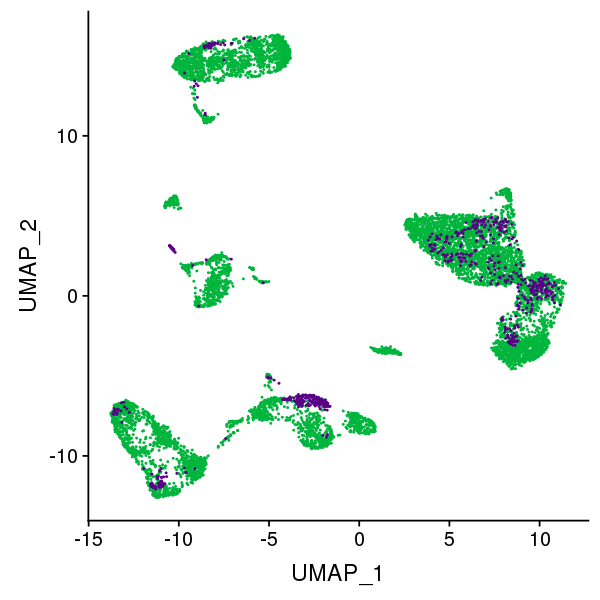

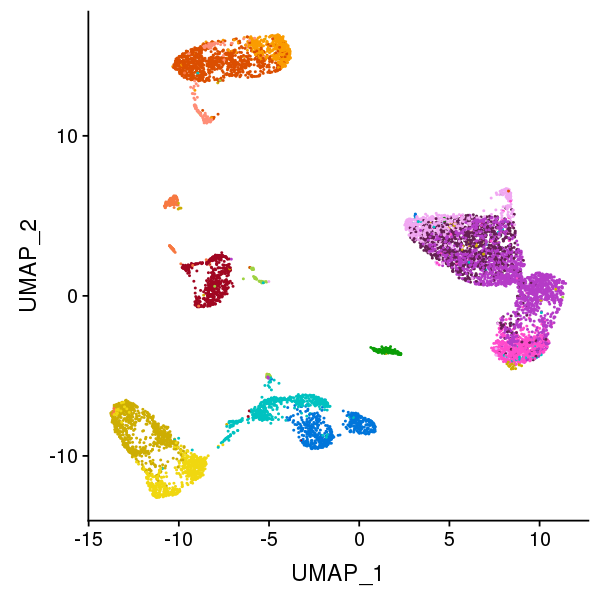

In [92]:
options(repr.plot.width = 5, repr.plot.height = 5)


# png("~/gtex_deconvolution/Reviews/liver_integrated_byIdent_umap.png", width = 3, height = 3, units = "in", res = 300)
DimPlot(integrated, group.by = "orig.ident", label = F, cols = c("#00b53c", "#5a0087"))+ NoLegend()
# dev.off()

# png("~/gtex_deconvolution/Reviews/liver_integrated_bySpecies_umap.png", width = 3, height = 3, units = "in", res = 300)
DimPlot(integrated, group.by = "cell_ontology_class_species", label = F, cols = final_cols) + NoLegend()
# dev.off()

In [124]:
skin_final_cols = c("#a3a737", "#e33b6b", "#34ade3", "#b5c200", "#edb02b", "#b04e09", "#b9a5cf",
                    "#09006b", "#75c1ff", "#366573",  "#11bab2", "#75c1ff", "#ef68a2", "#3ead2f", "#663d94", "orange"
                    )

In [115]:
integrated.epidermis@meta.data$final_naming_int = integrated.epidermis@meta.data$reannotated_cell_names
integrated.epidermis@meta.data[is.na(integrated.epidermis@meta.data$reannotated_cell_names), "final_naming_int"] = integrated.epidermis@meta.data[is.na(integrated.epidermis@meta.data$reannotated_cell_names), "free_annotation"]

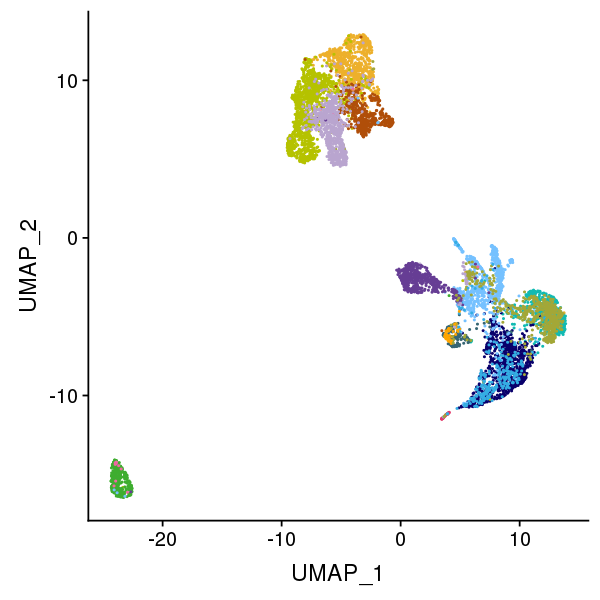

In [130]:
options(repr.plot.width = 5, repr.plot.height = 5)

# png("~/gtex_deconvolution/Reviews/skin_integrated_byIdent_umap.png", width = 3, height = 3, units = "in", res = 300)
# DimPlot(integrated.epidermis, group.by = "species", cols = c("#00b53c", "#5a0087"), label = F) + NoLegend()
# dev.off()

# png("~/gtex_deconvolution/Reviews/skin_integrated_bySpecies_umap.png", width = 3, height = 3, units = "in", res = 300)
DimPlot(integrated.epidermis, group.by = "final_naming_int", cols = skin_final_cols, label = F) + NoLegend()
# dev.off()